In [1]:
from datasets import load_dataset
from g2p_en import G2p
import matplotlib.pyplot as plt
import numpy as np
import requests
from transformers import AutoTokenizer
from tqdm import tqdm

g2p = G2p()

generics_kb = load_dataset(
    'community-datasets/generics_kb', name='generics_kb_best', split='train')
ponyspeech_dataset = load_dataset(
    'synthbot/pony-speech', split='train')

tokenizer = AutoTokenizer.from_pretrained("therealvul/tokenizer_g2pen")
# Taken from the tokenizer config file
config_file = requests.get('https://huggingface.co/therealvul/tokenizer_g2pen/resolve/main/tokenizer.json').json()
merges = [tuple(x.split()) for x in config_file['model']['merges']]

def phonemize(text):
    spl = text.split()
    l = []
    for s in spl:
        arpabet_string = ''.join(g2p(s))
        l.append(arpabet_string)
    return ' '.join(l)

ignore_tokens = set(['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]'])
ignore_token_ids = set(tokenizer.vocab[x] for x in ignore_tokens)

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/31 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [2]:
from collections import defaultdict

dataset_token_counts = {index: 0 for index in tokenizer.vocab.values()}

for text in tqdm(ponyspeech_dataset['transcription']):
    encoding = tokenizer.encode(phonemize(text))
    for index in encoding:
        dataset_token_counts[index] += 1

100%|███████████████████████████████████| 64783/64783 [00:51<00:00, 1263.89it/s]


In [3]:
n = 240000
generic_token_counts = {index: 0 for index in tokenizer.vocab.values()}

for test_text in tqdm(generics_kb.shuffle().select(range(n))['generic_sentence']):
    encoding = tokenizer.encode(phonemize(test_text))
    for index in encoding:
        generic_token_counts[index] += 1

100%|██████████████████████████████████| 240000/240000 [04:24<00:00, 905.70it/s]


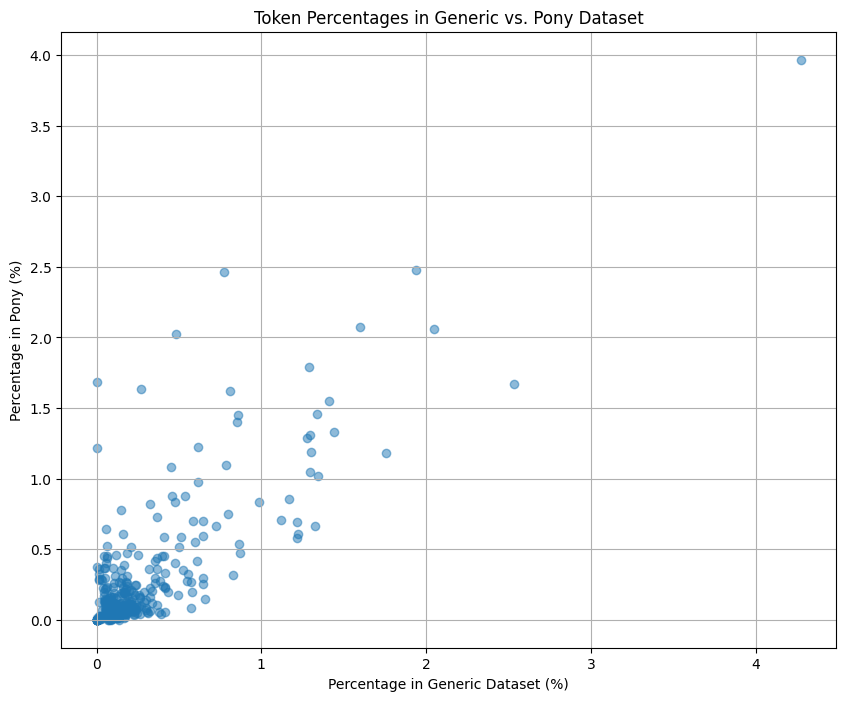

In [4]:
# Prepare data for scatter plot

# Map token IDs to tokens
id_to_token = {index: token for token, index in tokenizer.vocab.items()}

# Calculate Total Tokens and Percentages in Generic Dataset
total_generic_tokens = sum(generic_token_counts.values())
generic_token_percentages = {
    token_id: (count / total_generic_tokens) * 100
    for token_id, count in generic_token_counts.items()
}

# Optional: Calculate Total Tokens and Percentages in Pony
total_dataset_tokens = sum(dataset_token_counts.values())
dataset_token_percentages = {
    token_id: (count / total_dataset_tokens) * 100
    for token_id, count in dataset_token_counts.items()
}

all_tokens = set(generic_token_percentages.keys()).union(dataset_token_percentages.keys()) - ignore_tokens
token_list = [id_to_token[token_id] for token_id in all_tokens]
generic_percentages = [generic_token_percentages.get(token_id, 0) for token_id in all_tokens]
dataset_percentages = [dataset_token_percentages.get(token_id, 0) for token_id in all_tokens]

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(generic_percentages, dataset_percentages, alpha=0.5)
plt.xlabel('Percentage in Generic Dataset (%)')
plt.ylabel('Percentage in Pony (%)')
plt.title('Token Percentages in Generic vs. Pony Dataset')
plt.grid(True)
plt.show()


67


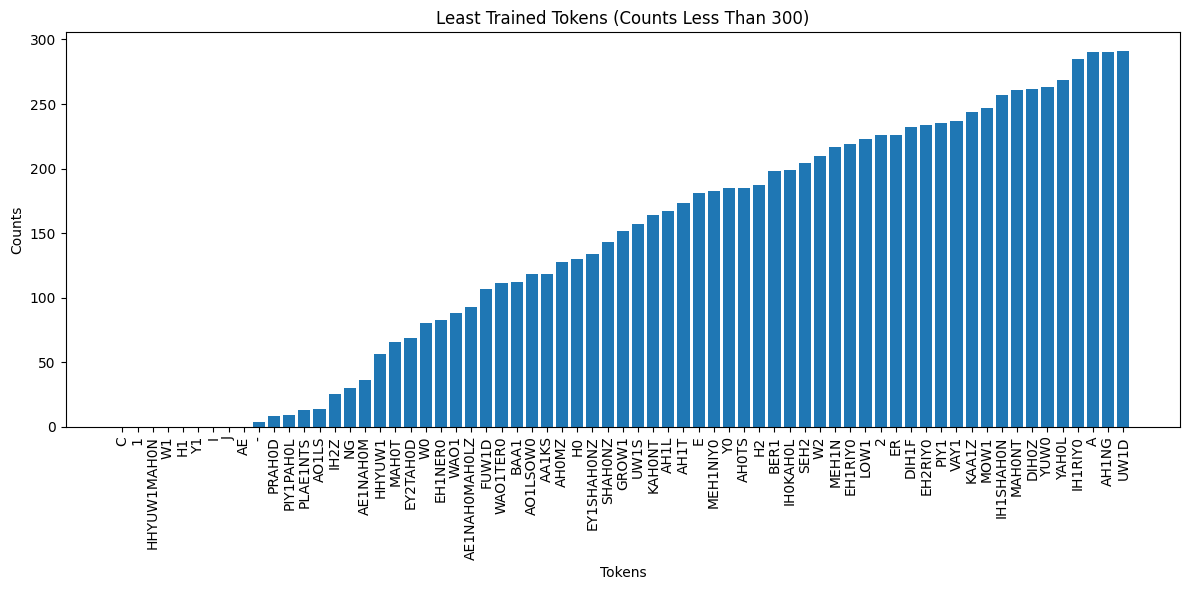

In [5]:
# Get least trained tokens (tokens with counts less than 300)
poorly_trained = sorted((item for item in dataset_token_counts.items() if item[1] < 300 and item[0] not in ignore_token_ids), key=lambda x: x[1])

# Print the number of poorly trained tokens
print(len(poorly_trained))

# Now, let's visualize the poorly trained tokens

# Extract tokens and counts
tokens = [id_to_token[p[0]] for p in poorly_trained]
counts = [p[1] for p in poorly_trained]

# Optionally, limit the number of tokens to display
# For example, display only the top 50 poorly trained tokens
top_n = 100
tokens = tokens[:top_n]
counts = counts[:top_n]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(tokens, counts)
plt.xlabel('Tokens')
plt.ylabel('Counts')
plt.title('Least Trained Tokens (Counts Less Than 300)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


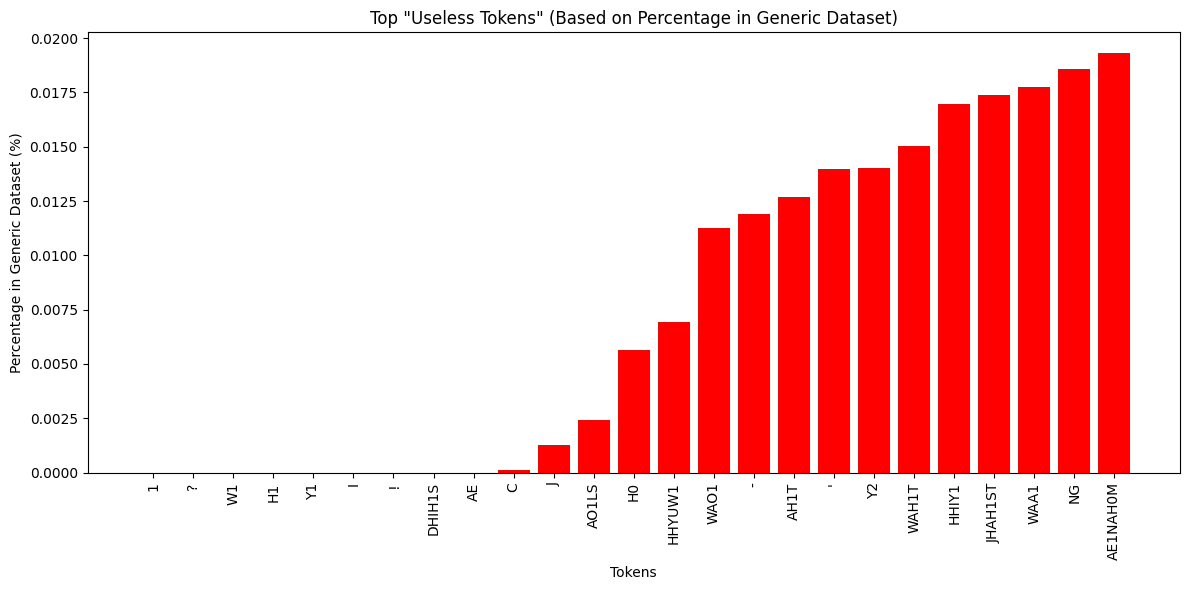

In [6]:
# Assuming 'dataset_token_counts', 'generic_token_counts', and 'id_to_token' are already defined

# Step 1: Calculate Total Tokens and Percentages in Generic Dataset
total_generic_tokens = sum(generic_token_counts.values())
generic_token_percentages = {
    token_id: (count / total_generic_tokens) * 100
    for token_id, count in generic_token_counts.items()
}

# Calculate Total Tokens and Percentages in Pony
total_dataset_tokens = sum(dataset_token_counts.values())
dataset_token_percentages = {
    token_id: (count / total_dataset_tokens) * 100
    for token_id, count in dataset_token_counts.items()
}

# Step 2: Define Thresholds Based on Percentages
useless_percentage_threshold = 0.02  # Tokens less than 0.01% are considered 'useless'

# Step 3: Identify 'Useless Tokens'
useless_tokens = {
    token_id: percentage
    for token_id, percentage in generic_token_percentages.items()
    if percentage < useless_percentage_threshold and token_id not in ignore_token_ids
}

# Step 4: Visualization

## Visualize 'Useless Tokens'

# Prepare data for visualization
tokens_useless = [id_to_token[token_id] for token_id in useless_tokens.keys()]
percentages_useless = list(useless_tokens.values())

# Sort tokens by percentages ascending
tokens_percentages_useless = sorted(zip(tokens_useless, percentages_useless), key=lambda x: x[1])
tokens_useless, percentages_useless = zip(*tokens_percentages_useless)

# Limit number of tokens for visualization
top_n_useless = 50  # Adjust as needed
tokens_useless = tokens_useless[:top_n_useless]
percentages_useless = percentages_useless[:top_n_useless]

# Plotting 'Useless Tokens'
plt.figure(figsize=(12, 6))
plt.bar(tokens_useless, percentages_useless, color='red')
plt.xlabel('Tokens')
plt.ylabel('Percentage in Generic Dataset (%)')
plt.title(f'Top "Useless Tokens" (Based on Percentage in Generic Dataset)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

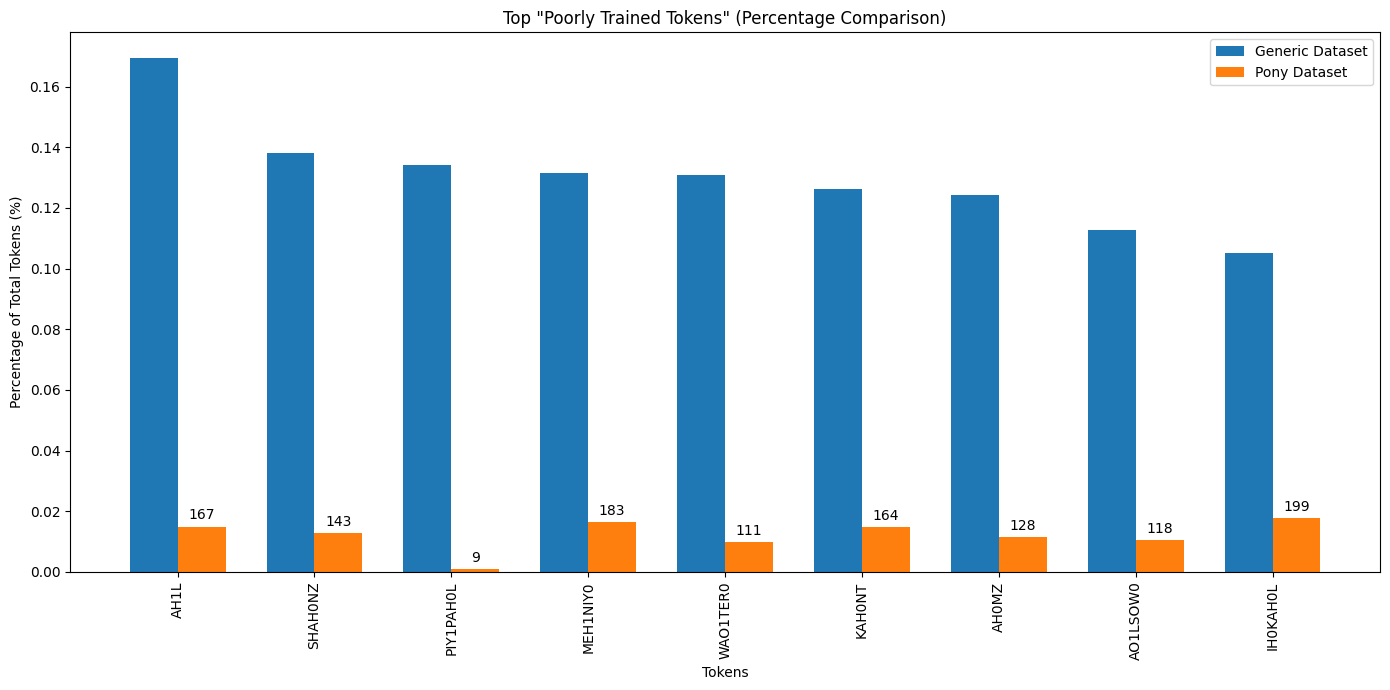

In [7]:
## Visualize 'Poorly Trained Tokens'

# Define a percentage threshold for 'underrepresented' in Pony
dataset_underrepresented_threshold = 200  # Tokens that appear less than 200 times in Pony
common_percentage_threshold = 0.1    # Tokens more than 0.1% are considered 'common' in generic dataset

poorly_trained_tokens = {
    token_id: (generic_percentage, dataset_token_percentages.get(token_id, 0))
    for token_id, generic_percentage in generic_token_percentages.items()
    if generic_percentage > common_percentage_threshold
       and dataset_token_counts.get(token_id, 0) < dataset_underrepresented_threshold
       and token_id not in ignore_token_ids
}

# Prepare data for visualization
tokens_poorly_trained = [id_to_token[token_id] for token_id in poorly_trained_tokens.keys()]
generic_percentages_poorly_trained = [values[0] for values in poorly_trained_tokens.values()]
dataset_percentages_poorly_trained = [values[1] for values in poorly_trained_tokens.values()]
dataset_counts_poorly_trained = [dataset_token_counts.get(token_id, 0) for token_id in poorly_trained_tokens.keys()]

# Sort tokens by generic percentages descending
tokens_data_poorly_trained = sorted(
    zip(tokens_poorly_trained, generic_percentages_poorly_trained, dataset_percentages_poorly_trained, dataset_counts_poorly_trained),
    key=lambda x: -x[1]
)
tokens_poorly_trained, generic_percentages_poorly_trained, dataset_percentages_poorly_trained, dataset_counts_poorly_trained = zip(*tokens_data_poorly_trained)

# Limit number of tokens for visualization
top_n_poorly_trained = 50  # Adjust as needed
tokens_poorly_trained = tokens_poorly_trained[:top_n_poorly_trained]
generic_percentages_poorly_trained = generic_percentages_poorly_trained[:top_n_poorly_trained]
dataset_percentages_poorly_trained = dataset_percentages_poorly_trained[:top_n_poorly_trained]
dataset_counts_poorly_trained = dataset_counts_poorly_trained[:top_n_poorly_trained]

# Plotting 'Poorly Trained Tokens'
x = np.arange(len(tokens_poorly_trained))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
rects1 = ax.bar(x - width/2, generic_percentages_poorly_trained, width, label='Generic Dataset')
rects2 = ax.bar(x + width/2, dataset_percentages_poorly_trained, width, label='Pony Dataset')

# Add labels and title
ax.set_xlabel('Tokens')
ax.set_ylabel('Percentage of Total Tokens (%)')
ax.set_title(f'Top "Poorly Trained Tokens" (Percentage Comparison)')
ax.set_xticks(x)
ax.set_xticklabels(tokens_poorly_trained, rotation=90)
ax.legend()

# Annotate the 'Pony Dataset' bars with the absolute counts from Pony
for rect, count in zip(rects2, dataset_counts_poorly_trained):
    height = rect.get_height()
    ax.annotate(f'{count}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # Offset text by 3 points vertically
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()
plt.show()


In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE

# Assuming the following are already defined:
# - dataset_token_counts
# - generic_token_counts
# - id_to_token
# - tokenizer

### Step 1: Identify "Poorly Trained" and "Useless" Tokens

# Identify "useless" tokens (uncommon in generic dataset)
useless_tokens = {
    token_id for token_id, percentage in generic_token_percentages.items() if percentage < useless_percentage_threshold
}

# Identify "poorly trained" tokens (common in generic but uncommon in dataset)
poorly_trained_tokens = {
    token_id for token_id, generic_percentage in generic_token_percentages.items()
    if generic_percentage > common_percentage_threshold and dataset_token_counts.get(token_id, 0) < dataset_underrepresented_threshold
}

# Combine "useless" and "poorly trained" tokens
combined_tokens = useless_tokens.union(poorly_trained_tokens)  - ignore_token_ids

### Step 2: Check if Splitting Tokens Results in Sub-Tokens That Are Neither "Poorly Trained" Nor "Useless"

# Prepare sets for faster lookup
poorly_trained_or_useless_tokens = useless_tokens.union(poorly_trained_tokens) - ignore_token_ids

# Create BPE tokenizers that ignore certain tokens
def create_subtokenizer(remove_tokens):
    merge_left = {}
    merge_right = {}
    for m in merges:
        left, right = m
        merge_left[left] = ''.join(m)
        merge_right[right] = ''.join(m)
    
    all_removals = remove_tokens.copy()
    pending_removals = remove_tokens.copy()
    while pending_removals:
        for r in pending_removals.copy():
            pending_removals.remove(r)
            
            if r in merge_left:
                pending_removals.add(merge_left[r])
                all_removals.add(merge_left[r])
                del merge_left[r]
            if r in merge_right:
                pending_removals.add(merge_right[r])
                all_removals.add(merge_right[r])
                del merge_right[r]
    
    submerges = []
    for m in merges:
        if m[0] in merge_left and m[1] in merge_right and ''.join(m) not in all_removals:
            submerges.append(m)
    
    
    subvocab = {k: v for k,v in tokenizer.vocab.items() if k not in all_removals}
    subtokenizer_model = BPE(vocab=subvocab, merges=submerges, unk_token=tokenizer.unk_token)
    subtokenizer = Tokenizer(subtokenizer_model)
    subtokenizer.pre_tokenizer = Whitespace()
    return subtokenizer

# Function to split a token until it's good
def split_token(token_id, remove_tokens=set()):
    if token_id not in poorly_trained_or_useless_tokens:
        return [token_id]

    token_str = id_to_token[token_id]
    if len(token_str) == 1:
        return [token_id]
    
    # Encode the token string using the tokenizer
    subtokenizer = create_subtokenizer(remove_tokens.union({token_str}))
    encoded_token_strs = subtokenizer.encode(token_str, add_special_tokens=False).tokens
    encoded_token_ids = [tokenizer.vocab[x] for x in encoded_token_strs]
    
    # Recursively split the subtokens
    all_subtokens = []
    for subtoken_id in encoded_token_ids:
        all_subtokens.extend(split_token(subtoken_id, remove_tokens))
    
    return all_subtokens

# Initialize list to collect tokens that meet the criteria
tokens_to_split = []
underrepresented_tokens = []

# Iterate over combined tokens
for token_id in combined_tokens:
    try:
        subtokens = split_token(token_id)
    except:
        continue
    
    token_str = id_to_token[token_id]
    
    if len(subtokens) == 1 and subtokens[0] in poorly_trained_tokens:
        underrepresented_tokens.append({
            'token': token_str,
            'original_token_id': token_id,
            'count_dataset': dataset_token_counts.get(token_id, 0),
            'count_generic': generic_token_counts.get(token_id, 0),
        })
    elif len(subtokens) != 1:
        tokens_to_split.append({
            'original_token': token_str,
            'original_token_id': token_id,
            'subtokens': [id_to_token[stid] for stid in subtokens],
            'subtoken_ids': subtokens,
            'original_count_dataset': dataset_token_counts.get(token_id, 0),
            'original_count_generic': generic_token_counts.get(token_id, 0),
            'subtoken_counts_dataset': [dataset_token_counts.get(x, 0) for x in subtokens],
            'subtoken_counts_generic': [generic_token_counts.get(x, 0) for x in subtokens],
        })
    

### Step 3: Output the Tokens That Meet the Criteria

# Print the results
print(f"Tokens that are poorly trained or useless and can be split into better sub-tokens ({len(tokens_to_split)} tokens):\n")
for item in tokens_to_split:
    print(f"Original Token: '{item['original_token']}'")
    print(f"  Token ID: {item['original_token_id']}")
    print(f"  Counts - Dataset: {item['original_count_dataset']}, Generic: {item['original_count_generic']}")
    print(f"  Sub-Tokens: {item['subtokens']}")
    print(f"  Sub-Token Counts - Dataset: {item['subtoken_counts_dataset']}, Generic: {item['subtoken_counts_generic']}")
    print()

print(f"Tokens that are underrepresented and can't be split into better sub-tokens ({len(underrepresented_tokens)} tokens):\n")
for item in underrepresented_tokens:
    print(f"Token: '{item['token']}'")
    print(f"  Token ID: {item['original_token_id']}")
    print(f"  Counts - Dataset: {item['count_dataset']}, Generic: {item['count_generic']}")
    print()
    

Tokens that are poorly trained or useless and can be split into better sub-tokens (26 tokens):

Original Token: 'WAO1TER0'
  Token ID: 259
  Counts - Dataset: 111, Generic: 7133
  Sub-Tokens: ['W', 'AO1', 'TER0']
  Sub-Token Counts - Dataset: [12081, 3459, 2752], Generic: [24711, 10148, 12986]

Original Token: 'KAH0NT'
  Token ID: 261
  Counts - Dataset: 164, Generic: 6880
  Sub-Tokens: ['K', 'AH0NT']
  Sub-Token Counts - Dataset: [23012, 4856], Generic: [111513, 20008]

Original Token: 'AH0MZ'
  Token ID: 264
  Counts - Dataset: 128, Generic: 6775
  Sub-Tokens: ['AH0M', 'Z']
  Sub-Token Counts - Dataset: [1989, 11718], Generic: [26849, 70528]

Original Token: 'AO1LS'
  Token ID: 284
  Counts - Dataset: 14, Generic: 131
  Sub-Tokens: ['AO1L', 'S']
  Sub-Token Counts - Dataset: [5153, 18668], Generic: [13793, 138018]

Original Token: 'NG'
  Token ID: 286
  Counts - Dataset: 30, Generic: 1012
  Sub-Tokens: ['N', 'G']
  Sub-Token Counts - Dataset: [16264, 18085], Generic: [72932, 44174]

